In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

#import matplotlib
#matplotlib.use('agg')
#import matplotlib.pyplot as plt 

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.show()

import tensorflow as tf
import sys, os, math
import gezi, melt
import numpy as np

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'
image_model_name='InceptionResnetV2'
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/showandtell'
if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, 
                                      model_name=image_model_name,
                                      feature_name=None)
else:
  image_model = None

predictor = melt.Predictor(model_dir)

model_dir2 = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.rnn.finetune.later'
#predictor2 = melt.Predictor(model_dir2)

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.2.0-rc0


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words


ENCODE_UNK 1


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
image_model feature_name is None will get PreLogits
image_feature: Tensor("InceptionResnetV2/Logits/Dropout/Identity:0", shape=(?, 1536), dtype=float32)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("Flatten/Reshape:0", shape=(?, 98304), dtype=float32)
INFO:tensorflow:Restoring parameters from /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt


restore image var from InceptionResnetV2 /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt duration: 24.675632


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model/showandtell/model.ckpt-73.4-301000


restore meta grpah and model ok /home/gezi/new/temp/image-caption/ai-challenger/model/showandtell/model.ckpt-73.4-301000 duration: 15.4848968983


In [3]:
def predict(image_path, predictor, length_normalization_factor=1., gen_feature=True, num_show=1):
  img = melt.read_image(image_path)
  if gen_feature:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]
  #print(feature)
  timer = gezi.Timer()
  graph = predictor.graph
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        ], 
                                        feed_dict= {
                                          graph.get_collection('feed')[0] : feature
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          graph.get_collection('feed')[0] : feature,
                                          graph.get_collection('beam_search_input_feed')[0] : input_feed,
                                          graph.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=ids2text.end_id(), 
                                   max_words=decode_max_words, 
                                   length_normalization_factor=length_normalization_factor)


  for i, beam in enumerate(beams):
    print(i, beam.words)
    print(i, ids2text.ids2text(beam.words), math.exp(beam.score))

    # Plot images with attention weights
    words = beam.words    
    print(beam.logprobs)
    print(predictor.inference(graph.get_collection('greedy_log_probs_list')[0],  {graph.get_collection('feed')[0] : feature}))
    print(predictor.inference(graph.get_collection('text_score')[0],  {graph.get_collection('feed')[0] : feature}))
    print(predictor.inference(graph.get_collection('beam_text_score')[0],  {graph.get_collection('feed')[0] : feature}))
    text = gezi.pad(list(beam.words)[:-1], 100)
    print(predictor.inference('score', {graph.get_collection('rfeed')[0]: [text], graph.get_collection('feed')[0] : feature}))  
    print(predictor.inference('exact_score', {graph.get_collection('rfeed')[0]: [text], graph.get_collection('feed')[0] : feature}))  
    print(predictor.inference('exact_prob', {graph.get_collection('rfeed')[0]: [text], graph.get_collection('feed')[0] : feature}))  


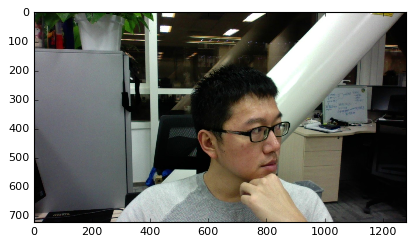

0 [103, 10, 4, 1, 82, 11, 10, 43, 140, 1, 14, 2, 343, 9]
0 室内/一个/人/的/前面/有/一个/戴着/眼镜/的/男人/在/下围棋/</S> 0.521984493589
[-2.1415114, -0.61772257, -1.5708202, -0.30693209, -0.57440656, -0.046127528, -0.02556424, -0.88196403, -0.069529094, -0.0032000546, -0.7744202, -0.23589493, -1.853456, -9.4409297e-05]
[[ -4.14217424e+00  -3.16095911e-03  -1.05277252e+00  -9.59104955e-01
   -2.01878405e+00  -7.43101314e-02  -2.76920875e-03  -1.27515244e+00
   -1.72312462e+00  -2.09770516e-01  -5.10476641e-02  -5.35144615e+00
   -1.01431899e-01  -4.64604092e+00  -1.54951215e-01  -4.65631628e+00
   -1.52164948e+00  -8.97838792e-04  -5.50117791e-01  -1.56861389e+00
   -1.11931258e-04]]
[ 0.06845107]
[[ 0.5219844   0.50643218  0.50246263]]
[[ 0.52198452]]
[[ 0.52198452]]
[[ 0.52198452]]
1 [103, 10, 4, 1, 82, 11, 10, 43, 140, 1, 14, 2, 555, 9]
1 室内/一个/人/的/前面/有/一个/戴着/眼镜/的/男人/在/打电话/</S> 0.506432067555
[-2.1415114, -0.61772257, -1.5708202, -0.30693209, -0.57440656, -0.046127528, -0.02556424, -0.88196403, -0.0695290

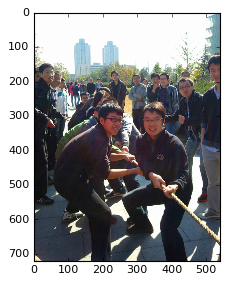

0 [52, 5, 132, 4, 1, 82, 11, 10, 43, 94, 1, 14, 306, 3, 10, 67, 844, 5, 1, 22, 9]
0 道路/上/一群/人/的/前面/有/一个/戴着/帽子/的/男人/推/着/一个/坐在/轮椅/上/的/女人/</S> 0.567355781378
[-1.9636865, -0.0042956462, -0.51901233, -0.44745648, -0.55822641, -0.8202911, -0.060823977, -0.32229105, -1.534176, -0.5396812, -0.0094916737, -1.0077498, -1.5072305, -0.01005843, -0.174619, -1.4519311, -0.53186226, -0.011121074, -0.0012963949, -0.35085788, -0.075985298]
[[ -1.96368647e+00  -4.29552747e-03  -5.19011378e-01  -4.47457671e-01
   -5.58225811e-01  -1.12009501e+00  -5.07451706e-02  -2.82930374e-01
   -2.37088609e+00  -7.94826889e+00  -3.81207117e-03  -7.32077241e-01
   -2.39939117e+00  -5.13521338e+00  -1.75814480e-02  -8.28028992e-02]]
[ 0.28197575]
[[ 0.56735575  0.56388324  0.5525555 ]]
[[ 0.56735599]]
[[ 0.56735599]]
[[ 0.56735599]]
1 [52, 5, 132, 4, 1, 82, 11, 10, 43, 94, 1, 14, 306, 3, 10, 46, 3, 4, 1, 844, 9]
1 道路/上/一群/人/的/前面/有/一个/戴着/帽子/的/男人/推/着/一个/坐/着/人/的/轮椅/</S> 0.563883334872
[-1.9636865, -0.0042956462, -0.51901

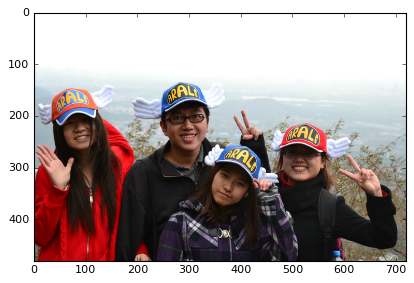

0 [27, 43, 94, 1, 22, 33, 10, 44, 18, 3, 133, 1, 14, 19, 2, 105, 1, 52, 5, 9]
0 两个/戴着/帽子/的/女人/和/一个/双手/拿/着/东西/的/男人/站/在/室外/的/道路/上/</S> 0.519838209277
[-1.079571, -1.9397899, -0.6558826, -0.016878646, -1.0721428, -0.43085259, -0.042446956, -1.4455248, -0.29843509, -0.0023271164, -1.9008758, -0.013659812, -0.32307243, -0.2032245, -0.00062958442, -1.1105266, -0.48932666, -2.0479448, -0.0039639482, -0.0076782806]
[[ -1.51904798e+00  -3.29195380e+00  -4.22539997e+00  -1.45566535e+00
   -5.95936133e-03  -5.36491096e-01  -7.85159302e+00  -3.64996940e-02
   -6.25902414e-01  -4.22465515e+00  -7.74372518e-02  -2.20912881e-03
   -7.66450882e+00  -1.09859612e-02  -1.27600217e+00  -4.46674913e-01
   -4.45624231e-04  -7.70005608e+00  -1.20656538e+00  -4.92101049e+00
   -8.10228214e-02  -6.61395788e-02]]
[ 0.38271847]
[[ 0.51983809  0.51580405  0.51558816]]
[[ 0.51983809]]
[[ 0.51983809]]
[[ 0.51983809]]
1 [27, 43, 94, 1, 22, 33, 10, 44, 18, 3, 133, 1, 14, 19, 2, 105, 1, 440, 5, 9]
1 两个/戴着/帽子/的/女人/和/一个

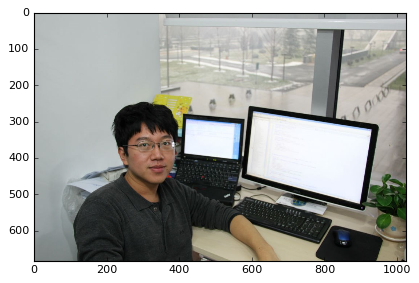

0 [89, 21, 11, 10, 43, 140, 1, 14, 33, 10, 20, 113, 90, 1, 22, 2, 115, 969, 45, 766, 9]
0 房间/里/有/一个/戴着/眼镜/的/男人/和/一个/穿着/黑色/上衣/的/女人/在/看/同一/台/电脑/</S> 0.533226605803
[-1.3008322, -0.0045992304, -0.46767575, -0.12754127, -1.6786746, -0.16077188, -0.0048233583, -0.36555776, -1.1497564, -0.013934822, -1.4556359, -1.795126, -0.95478034, -0.0022249485, -0.55275768, -0.36834717, -1.0510447, -1.3614979, -0.25180951, -0.13348095, -0.0041131903]
[[ -1.53431547e+00  -4.86882973e+00  -5.18696010e-02  -1.62957376e-03
   -1.86520362e+00  -1.00797908e-02  -2.30576348e+00  -9.51228619e-01
   -4.01689708e-02  -3.20478201e+00  -8.43994413e-03  -1.00483537e+00
   -1.34643221e+00  -8.07117558e+00  -4.46273051e-02  -2.31015134e+00
   -1.30225897e+01  -1.40746415e-01]]
[ 0.38241413]
[[ 0.53322667  0.52174652  0.5195958 ]]
[[ 0.53322661]]
[[ 0.53322661]]
[[ 0.53322661]]
1 [89, 21, 11, 10, 43, 140, 1, 14, 33, 10, 20, 113, 90, 1, 22, 2, 115, 766, 9]
1 房间/里/有/一个/戴着/眼镜/的/男人/和/一个/穿着/黑色/上衣/的/女人/在/看/电脑/</S> 0.52174655

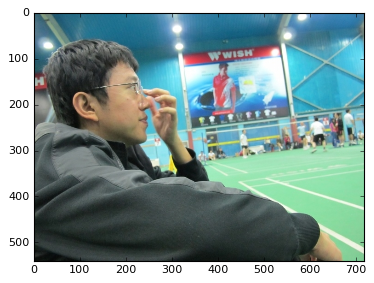

0 [62, 5, 11, 10, 42, 18, 3, 98, 1, 14, 2, 736, 10, 67, 229, 5, 1, 14, 9]
0 运动场/上/有/一个/右手/拿/着/话筒/的/男人/在/采访/一个/坐在/椅子/上/的/男人/</S> 0.604825375865
[-1.575631, -0.061342426, -0.48253423, -0.099534497, -1.4571875, -0.2289134, -0.013035909, -0.9050706, -0.011372975, -0.11412261, -0.2300283, -1.6349627, -0.14385878, -1.7445288, -0.442184, -0.0024126251, -0.010096431, -0.38030913, -0.016367814]
[[ -1.57563102e+00  -6.13426492e-02  -4.82536435e-01  -9.95342806e-02
   -1.45719206e+00  -4.47991657e+00  -3.03968358e+00  -1.23607526e-02
   -2.40145531e-02  -3.43230152e+00  -3.35699975e-01  -3.30314803e+00
   -4.94953652e-04]]
[ 0.14204977]
[[ 0.60482526  0.59822589  0.58776689]]
[[ 0.60482526]]
[[ 0.60482526]]
[[ 0.60482526]]
1 [62, 5, 11, 10, 42, 18, 3, 98, 1, 14, 2, 262, 9]
1 运动场/上/有/一个/右手/拿/着/话筒/的/男人/在/讲话/</S> 0.598226167939
[-1.575631, -0.061342426, -0.48253423, -0.099534497, -1.4571875, -0.2289134, -0.013035909, -0.9050706, -0.011372975, -0.11412261, -0.2300283, -1.5003439, -0.00010573305]
[[-1

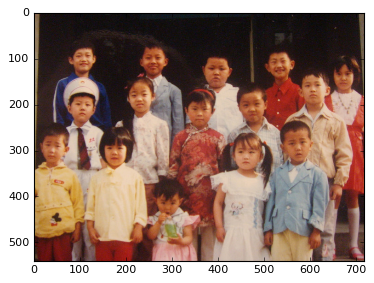

0 [273, 1, 89, 21, 19, 3, 132, 44, 146, 279, 1, 207, 9]
0 明亮/的/房间/里/站/着/一群/双手/放在/身前/的/女孩/</S> 0.552569879672
[-2.4290564, -0.061320785, -0.28569475, -0.0023947866, -0.21276878, -0.008004019, -0.46933264, -1.5429885, -1.3168875, -0.21175116, -0.019384002, -1.07882, -0.072876789]
[[ -2.42905641e+00  -6.13207854e-02  -2.85695285e-01  -2.39478657e-03
   -2.12768301e-01  -8.00401904e-03  -6.01064539e+00  -1.79214323e+00
   -3.24632883e+00  -8.73337507e-01  -8.68578535e-03  -2.02294779e+00
   -1.94140032e-01]]
[ 0.05571624]
[[ 0.55256969  0.54660916  0.54088008]]
[[ 0.55256957]]
[[ 0.55256957]]
[[ 0.55256957]]
1 [273, 1, 89, 21, 19, 3, 132, 44, 18, 3, 133, 1, 207, 9]
1 明亮/的/房间/里/站/着/一群/双手/拿/着/东西/的/女孩/</S> 0.54660947912
[-2.4290564, -0.061320785, -0.28569475, -0.0023947866, -0.21276878, -0.008004019, -0.46933264, -1.5429885, -1.1560122, -0.066603862, -1.0508039, -0.034443434, -0.99334919, -0.14351648]
[[ -1.95827031e+00  -1.03324896e-03  -2.57128143e+00  -6.55515003e+00
   -1.00976682e+00  -2

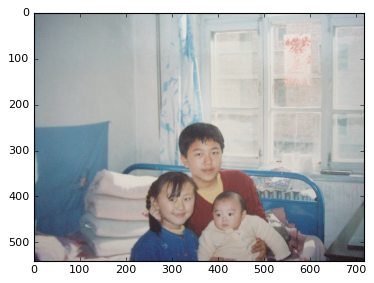

0 [89, 21, 1, 380, 46, 3, 70, 20, 352, 1, 152, 9]
0 房间/里/的/床上/坐/着/三个/穿着/各异/的/孩子/</S> 0.471720100685
[-1.3846244, -0.0047791065, -2.1322794, -0.28736895, -1.2685108, -0.00039796063, -0.7747137, -1.1268266, -1.0048996, -0.025451403, -1.0001445, -0.0064373985]
[[ -1.38462436e+00  -4.77910647e-03  -9.25932884e-01  -5.50388765e+00
   -8.37209076e-03  -5.54023123e+00  -5.65981902e-02  -6.67783380e-01
   -2.84960723e+00  -4.15366650e+00  -4.00034904e+00  -4.21325207e+00
   -5.48643619e-02  -7.62841165e-01  -2.50899386e+00  -1.31514281e-01]]
[ 0.12325905]
[[ 0.47172007  0.47133979  0.436506  ]]
[[ 0.47172007]]
[[ 0.47172007]]
[[ 0.47172007]]
1 [89, 21, 1, 380, 46, 3, 70, 20, 352, 1, 183, 9]
1 房间/里/的/床上/坐/着/三个/穿着/各异/的/小孩/</S> 0.471340078447
[-1.3846244, -0.0047791065, -2.1322794, -0.28736895, -1.2685108, -0.00039796063, -0.7747137, -1.1268266, -1.0048996, -0.025451403, -1.0102544, -0.0059992955]
[[ -1.65842044e+00  -2.87533855e+00  -2.57195854e+00  -7.42390892e-03
   -6.63494229e-01  -1.6999757

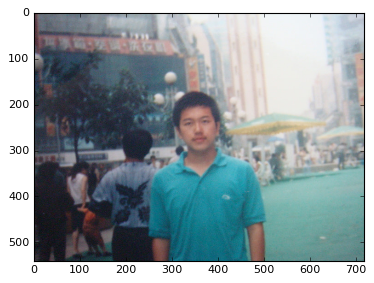

0 [10, 20, 210, 90, 1, 14, 33, 10, 43, 140, 1, 22, 19, 2, 52, 5, 9]
0 一个/穿着/短袖/上衣/的/男人/和/一个/戴着/眼镜/的/女人/站/在/道路/上/</S> 0.609471167073
[-0.36193195, -1.2534446, -1.1047176, -0.89317989, -0.013685799, -0.16824712, -0.37411141, -0.0066474969, -1.9272697, -0.44117433, -0.0057773273, -0.43501887, -0.33161277, -0.0011884063, -0.98615706, -0.0020304555, -0.11158736]
[[ -3.61931950e-01  -2.13718271e+00  -4.08887339e+00  -4.90806007e+00
   -4.81224507e-01  -8.71603936e-03  -1.56922400e-01  -3.13473314e-01
   -7.88125861e-03  -1.49733770e+00  -2.35072088e+00  -7.24284053e-01
   -6.55998707e-01  -1.87956810e-01  -1.97049417e-03  -5.07360363e+00
   -5.82676589e-01  -3.02031077e-02]]
[ 0.52015603]
[[ 0.60947102  0.59829366  0.5977183 ]]
[[ 0.60947102]]
[[ 0.60947102]]
[[ 0.60947102]]
1 [10, 20, 210, 90, 1, 14, 33, 10, 20, 144, 90, 1, 22, 19, 2, 52, 5, 9]
1 一个/穿着/短袖/上衣/的/男人/和/一个/穿着/白色/上衣/的/女人/站/在/道路/上/</S> 0.598293821432
[-0.36193195, -1.2534446, -1.1047176, -0.89317989, -0.013685799, -0.16824712, -0.

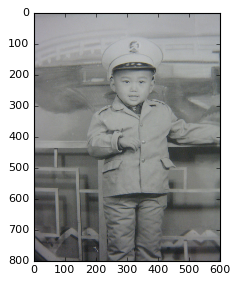

0 [27, 43, 94, 1, 4, 19, 2, 188, 64, 1, 52, 5, 9]
0 两个/戴着/帽子/的/人/站/在/房屋/外/的/道路/上/</S> 0.55026694105
[-2.0915375, -0.51642561, -0.40404505, -0.08912234, -0.34152964, -0.65417492, -0.0032554271, -2.0576336, -0.76589739, -0.044547498, -0.59952152, -0.002527735, -0.19535458]
[[ -8.68242645e+00  -7.18475282e-02  -9.02298927e+00  -6.81117535e+00
   -6.55774713e-01  -1.10460358e+01  -7.16220093e+00  -1.65773857e+00
   -8.10529137e+00  -8.40478134e+00  -1.64902759e+00  -6.60131220e-03]]
[ 0.21019451]
[[ 0.55026704  0.51854509  0.49157059]]
[[ 0.55026704]]
[[ 0.55026704]]
[[ 0.55026704]]
1 [27, 43, 94, 1, 4, 19, 2, 103, 1, 212, 29, 9]
1 两个/戴着/帽子/的/人/站/在/室内/的/桌子/旁/</S> 0.518544835114
[-2.0915375, -0.51642561, -0.40404505, -0.08912234, -0.34152964, -0.65417492, -0.0032554271, -1.9556563, -0.10220808, -1.2865806, -0.11275323, -0.3234565]
[[ -3.37359524e+00  -2.79268241e+00  -1.06230553e-03  -3.92037034e-01
   -1.51218069e+00  -2.62817121e+00  -2.17895460e+00  -1.46500182e+00
   -6.39282036e+00  -6

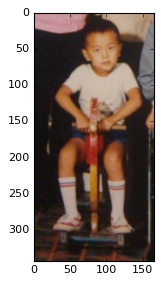

0 [65, 5, 10, 44, 18, 3, 98, 1, 22, 75, 11, 10, 42, 18, 3, 98, 1, 14, 2, 231, 9]
0 舞台/上/一个/双手/拿/着/话筒/的/女人/旁边/有/一个/右手/拿/着/话筒/的/男人/在/说话/</S> 0.589686560299
[-1.1675601, -0.021801222, -0.54564798, -1.904729, -0.76923436, -0.011508035, -0.35046902, -0.0082234833, -0.74759686, -1.5469645, -0.3049722, -0.022320945, -1.6238405, -0.14105839, -0.038093626, -0.10797316, -0.0024221388, -0.41902679, -0.46301544, -0.89496881, -2.0622994e-05]
[[ -9.40688705e+00  -4.80933762e+00  -2.91179493e-02  -3.36986446e+00
   -1.83742356e+00  -5.38536131e-01  -3.27194319e-03  -3.44796836e-01
   -9.36921407e-03  -5.81879854e+00  -3.28712082e+00  -1.28156662e+00
   -1.15983916e-04  -1.01013571e-01  -1.66393054e+00  -3.47631335e-01
   -5.15500875e-03  -2.31218427e-01  -4.46502194e-02  -5.01126051e-01
   -5.00853173e-03]]
[ 0.32643214]
[[ 0.58968651  0.58347005  0.5804196 ]]
[[ 0.58968651]]
[[ 0.58968651]]
[[ 0.58968651]]
1 [65, 5, 10, 44, 18, 3, 98, 1, 14, 75, 11, 10, 42, 18, 3, 98, 1, 22, 2, 231, 9]
1 舞台/上/一个/双手/

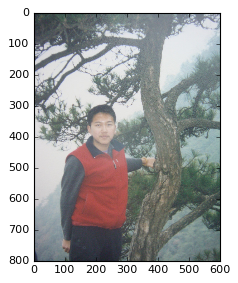

0 [597, 21, 11, 10, 20, 258, 90, 1, 22, 67, 2111, 5, 9]
0 树林/里/有/一个/穿着/红色/上衣/的/女人/坐在/树干/上/</S> 0.514082722438
[-1.9030592, -0.045667868, -0.70367497, -0.0065043173, -0.83639395, -0.99782097, -1.0752991, -0.013382374, -0.1783933, -1.2634368, -1.5909981, -0.028190752, -0.0070031658]
[[ -9.16837990e-01  -5.91362810e+00  -9.10369992e-01  -7.95161009e-01
   -1.84185896e-02  -4.13040444e-03  -4.68494606e+00  -4.54208374e+00
   -6.59425735e-01  -6.69450188e+00  -5.97112417e-01  -2.48350017e-03
   -8.88958097e-01  -2.30485946e-01  -1.41389415e-01]]
[ 0.14236753]
[[ 0.51408267  0.49236986  0.44719207]]
[[ 0.51408249]]
[[ 0.51408249]]
[[ 0.51408249]]
1 [597, 21, 11, 10, 20, 258, 90, 1, 22, 67, 1602, 5, 9]
1 树林/里/有/一个/穿着/红色/上衣/的/女人/坐在/大树/上/</S> 0.492369945123
[-1.9030592, -0.045667868, -0.70367497, -0.0065043173, -0.83639395, -0.99782097, -1.0752991, -0.013382374, -0.1783933, -1.2634368, -2.0160232, -0.1642697, -0.0068986332]
[[ -5.53489447e+00  -3.49825430e+00  -2.42927414e-03  -1.31040484e-01
 

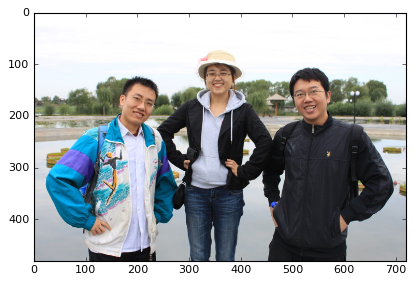

0 [70, 20, 187, 248, 1, 14, 24, 2, 105, 1, 52, 5, 9]
0 三个/穿着/深色/外套/的/男人/走/在/室外/的/道路/上/</S> 0.560889330473
[-0.81805176, -0.96664697, -1.3554065, -1.1429782, -0.030971622, -0.15225752, -0.62177193, -0.0014631767, -1.3538707, -0.053215466, -1.0178156, -0.0015379279, -0.0010240793]
[[ -8.18051755e-01  -1.92298126e+00  -1.34301996e+00  -1.32846227e-02
   -6.50957882e-01  -1.79757023e+00  -5.04067540e-03  -3.55199122e+00
   -4.14552164e+00  -9.84764636e-01  -1.15869874e-02  -2.29036575e-03]]
[ 0.27785048]
[[ 0.56088895  0.5600636   0.5280869 ]]
[[ 0.56088912]]
[[ 0.56088912]]
[[ 0.56088912]]
1 [70, 20, 187, 248, 1, 14, 24, 2, 52, 5, 9]
1 三个/穿着/深色/外套/的/男人/走/在/道路/上/</S> 0.560063888746
[-0.81805176, -0.96664697, -1.3554065, -1.1429782, -0.030971622, -0.15225752, -0.62177193, -0.0014631767, -1.1874326, -0.0024203551, -0.09734758]
[[ -2.02523756e+00  -2.06917024e+00  -1.07545233e+00  -1.48772057e-02
   -3.90950412e-01  -3.05503249e-01  -4.62372184e-01  -9.11400604e+00
   -4.85669196e-01  -1.2618

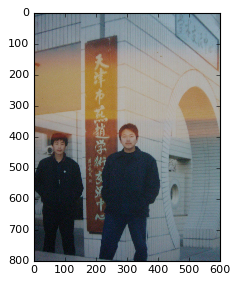

0 [10, 44, 146, 279, 1, 22, 33, 10, 44, 146, 279, 1, 14, 19, 2, 104, 21, 9]
0 一个/双手/放在/身前/的/女人/和/一个/双手/放在/身前/的/男人/站/在/大厅/里/</S> 0.558171963338
[-1.564916, -1.6837873, -0.82044697, -0.57083499, -0.0028901019, -0.48014355, -0.093683623, -0.1106814, -0.84635252, -1.2291042, -0.50786209, -0.0032675469, -0.60719967, -0.085046127, -0.0014844838, -1.8260949, -0.040262528, -0.021529185]
[[ -2.00270224e+00  -3.57241344e+00  -7.81489253e-01  -2.23313904e+00
   -8.92606005e-02  -1.39217854e+00  -2.23976564e+00  -1.01550494e-03
   -1.36848898e+01  -4.99865055e+00  -3.26341599e-01  -4.07201499e-01]]
[ 0.28051218]
[[ 0.55817187  0.54245895  0.53743279]]
[[ 0.55817199]]
[[ 0.55817199]]
[[ 0.55817199]]
1 [10, 44, 146, 279, 1, 22, 33, 10, 44, 146, 279, 1, 22, 19, 2, 104, 21, 9]
1 一个/双手/放在/身前/的/女人/和/一个/双手/放在/身前/的/女人/站/在/大厅/里/</S> 0.542459165889
[-1.564916, -1.6837873, -0.82044697, -0.57083499, -0.0028901019, -0.48014355, -0.093683623, -0.1106814, -0.84635252, -1.2291042, -0.50786209, -0.0032675469, -1.0

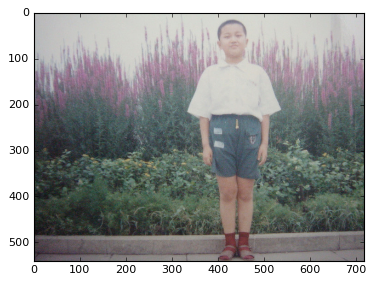

0 [10, 20, 210, 90, 1, 14, 19, 2, 52, 5, 9]
0 一个/穿着/短袖/上衣/的/男人/站/在/道路/上/</S> 0.565020413893
[-0.64501715, -0.57828927, -1.2340784, -0.69199997, -0.061651032, -0.11998814, -1.0451429, -0.0007800397, -1.7203929, -0.0093087461, -0.173179]
[[ -6.45017147e-01  -3.05280972e+00  -6.08160913e-01  -1.23485297e-01
   -5.71889766e-02  -2.06594515e+00  -2.96316957e+00  -6.27607822e-01
   -5.50009155e+00  -3.57646346e-02  -2.50907004e-01  -5.01019210e-02
   -1.18435812e+00  -3.35356896e-03  -4.21279036e-02]]
[ 0.33707091]
[[ 0.56502038  0.56042904  0.55901527]]
[[ 0.56502044]]
[[ 0.56502044]]
[[ 0.56502044]]
1 [10, 20, 250, 1, 14, 19, 2, 105, 1, 52, 5, 9]
1 一个/穿着/短裤/的/男人/站/在/室外/的/道路/上/</S> 0.560429128393
[-0.64501715, -0.57828927, -1.3564253, -0.082104407, -0.10382591, -1.2234837, -0.00058812485, -1.7890551, -0.01064645, -1.1462557, -0.0030094355, -0.0099294297]
[[ -6.45017147e-01  -5.78287959e-01  -1.35642159e+00  -8.21039677e-02
   -1.03825271e-01  -2.03833294e+00  -6.20768464e-04  -6.35242271e+0

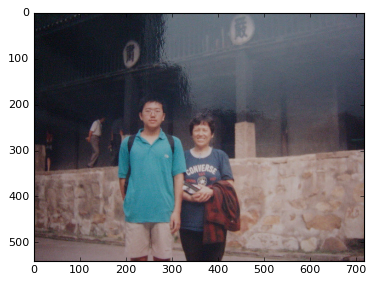

0 [10, 44, 146, 279, 1, 22, 33, 10, 44, 146, 279, 1, 22, 19, 2, 52, 5, 9]
0 一个/双手/放在/身前/的/女人/和/一个/双手/放在/身前/的/女人/站/在/道路/上/</S> 0.61086367838
[-1.1069067, -1.3960464, -1.1809618, -0.38023335, -0.0025177468, -0.4740243, -0.087513834, -0.048648305, -0.97281528, -0.93977571, -0.25210333, -0.0044948021, -0.68477595, -0.054798573, -0.0021008819, -1.2413909, -0.0034711843, -0.039287958]
[[-2.7661283  -1.20885074 -9.8327055  -0.78349441 -0.56448632 -0.47846505
  -2.07163167 -4.31572628 -0.09222802 -0.24276187 -0.02297112 -0.31809232
  -1.14484048 -3.84018755 -2.02643394 -0.01793149]]
[ 0.37441161]
[[ 0.61086357  0.61070824  0.60327315]]
[[ 0.61086375]]
[[ 0.61086375]]
[[ 0.61086375]]
1 [10, 44, 146, 279, 1, 14, 33, 10, 44, 146, 279, 1, 22, 19, 2, 52, 5, 9]
1 一个/双手/放在/身前/的/男人/和/一个/双手/放在/身前/的/女人/站/在/道路/上/</S> 0.610708250396
[-1.1069067, -1.3960464, -1.1809618, -0.38023335, -0.0025177468, -1.2860341, -0.10622825, -0.040983878, -0.92190218, -0.86815691, -0.17996952, -0.0043265074, -0.097391486, -0.

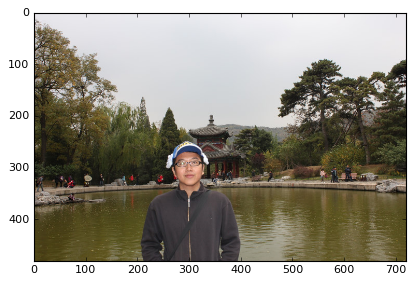

0 [10, 43, 154, 1, 14, 19, 2, 773, 1, 52, 5, 9]
0 一个/戴着/墨镜/的/男人/站/在/湖边/的/道路/上/</S> 0.521730115929
[-1.1594584, -1.0087347, -0.60257185, -0.05768647, -0.22649847, -1.6925559, -0.0026925283, -0.85503894, -0.041414127, -2.1102178, -0.0023124877, -0.048076313]
[[ -1.92396665e+00  -1.68053794e+00  -2.53830664e-02  -1.34141147e+00
   -8.45343351e-01  -4.30953410e-03  -1.93819714e+00  -8.85866582e-03
   -1.97368369e-01  -7.13817775e-01  -5.74175310e+00  -2.41659526e-02]]
[ 0.25689277]
[[ 0.52173007  0.50284058  0.49541393]]
[[ 0.52173036]]
[[ 0.52173036]]
[[ 0.52173036]]
1 [10, 43, 154, 1, 14, 19, 2, 773, 1, 2008, 5, 9]
1 一个/戴着/墨镜/的/男人/站/在/湖边/的/木桥/上/</S> 0.502840489456
[-1.1594584, -1.0087347, -0.60257185, -0.05768647, -0.22649847, -1.6925559, -0.0026925283, -0.85503894, -0.041414127, -2.571471, -0.0093874009, -0.022277461]
[[ -4.54950428e+00  -1.90705395e+00  -1.91904712e+00  -1.20308387e+00
   -7.17620773e-04  -1.39598742e-01  -8.97872329e-01  -2.23986387e+00
   -6.69692934e-01  -4.60339524

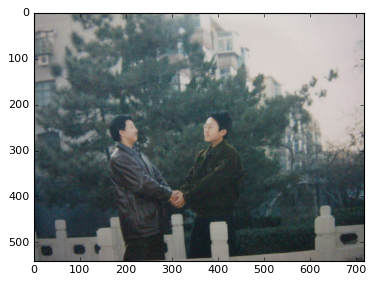

0 [10, 20, 113, 248, 1, 14, 33, 10, 43, 94, 1, 14, 19, 2, 52, 5, 9]
0 一个/穿着/黑色/外套/的/男人/和/一个/戴着/帽子/的/男人/站/在/道路/上/</S> 0.553944684608
[-1.0576904, -1.6674495, -0.90709531, -1.1598351, -0.012937536, -0.18895027, -0.38807374, -0.01355562, -1.3098452, -0.97154069, -0.011527714, -0.63334405, -0.24032038, -0.001760958, -1.084451, -0.0057082265, -0.38765252]
[[ -7.37031555e+00  -3.84554975e-02  -1.15256691e+00  -4.35214536e-03
   -5.80609977e-01  -3.52205324e+00  -2.34499481e-02  -9.99077129e+00
   -5.04611731e-02  -6.33499324e-01  -3.26338321e-01]]
[ 0.10600481]
[[ 0.55394471  0.54991221  0.54232627]]
[[ 0.55394459]]
[[ 0.55394459]]
[[ 0.55394459]]
1 [10, 20, 113, 248, 1, 14, 33, 10, 43, 154, 1, 14, 19, 2, 52, 5, 9]
1 一个/穿着/黑色/外套/的/男人/和/一个/戴着/墨镜/的/男人/站/在/道路/上/</S> 0.549912165978
[-1.0576904, -1.6674495, -0.90709531, -1.1598351, -0.012937536, -0.18895027, -0.38807374, -0.01355562, -1.3098452, -1.0805829, -0.0097635817, -0.70457566, -0.24142389, -0.0019582398, -1.0233848, -0.005476472, -0.39334

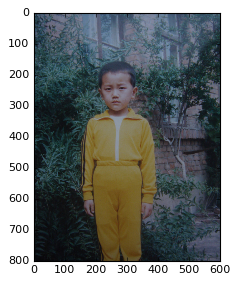

0 [10, 44, 108, 2, 340, 21, 1, 14, 19, 2, 52, 5, 9]
0 一个/双手/插/在/口袋/里/的/男人/站/在/道路/上/</S> 0.616589724238
[-0.68192446, -0.85207164, -0.96870631, -0.73507392, -0.40576291, -0.0080120601, -0.015346539, -0.48990417, -0.33322376, -0.0031577507, -1.6317173, -0.0080731977, -0.1531944]
[[ -5.29263926e+00  -4.88635199e-03  -9.46990013e+00  -1.07205677e+01
   -2.12821096e-01  -9.61437414e-04  -6.58024326e-02  -3.22931576e+00
   -7.03784227e-02  -2.97943449e+00  -2.92516663e-03]]
[ 0.11444429]
[[ 0.61658967  0.57072419  0.56771201]]
[[ 0.61658967]]
[[ 0.61658967]]
[[ 0.61658967]]
1 [10, 44, 108, 2, 340, 21, 1, 14, 19, 2, 105, 1, 52, 5, 9]
1 一个/双手/插/在/口袋/里/的/男人/站/在/室外/的/道路/上/</S> 0.57072420486
[-0.68192446, -0.85207164, -0.96870631, -0.73507392, -0.40576291, -0.0080120601, -0.015346539, -0.48990417, -0.33322376, -0.0031577507, -1.7762514, -0.16336298, -1.9761804, -0.0031004713, -0.0006590102]
[[ -8.75162315e+00  -9.23564599e-04  -3.76707268e+00  -5.84357405e+00
   -1.93554740e-02  -3.15836859e+00  

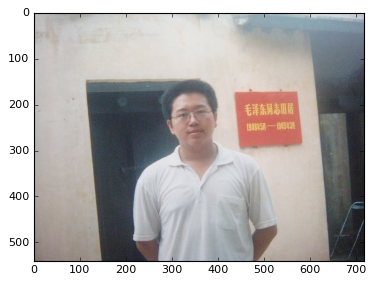

0 [10, 43, 140, 1, 14, 19, 2, 188, 64, 1, 52, 5, 9]
0 一个/戴着/眼镜/的/男人/站/在/房屋/外/的/道路/上/</S> 0.609646979798
[-0.50270653, -2.2721398, -0.24667591, -0.047136854, -0.1840173, -0.65939003, -0.00066627713, -0.94094968, -0.91329849, -0.11981939, -0.42713127, -0.0048913346, -0.11455484]
[[ -5.02706528e-01  -8.15961957e-01  -9.17649269e-01  -1.05068517e+00
   -3.50344442e-02  -2.89103121e-01  -4.89579856e-01  -1.00038061e-03
   -2.62851334e+00  -3.12889367e-02  -3.63100767e-01  -6.23957720e-03
   -5.64357378e-02]]
[ 0.38068795]
[[ 0.60964686  0.578399    0.56445622]]
[[ 0.60964692]]
[[ 0.60964692]]
[[ 0.60964692]]
1 [10, 20, 210, 90, 1, 14, 19, 2, 188, 64, 1, 52, 5, 9]
1 一个/穿着/短袖/上衣/的/男人/站/在/房屋/外/的/道路/上/</S> 0.57839889627
[-0.50270653, -0.81596017, -1.1729634, -0.57678759, -0.021185065, -0.19983807, -0.51757061, -0.00065055187, -1.2258326, -1.1704988, -0.90579945, -0.49875569, -0.0052861678, -0.051046077]
[[ -5.02706528e-01  -2.60104656e+00  -1.00172472e+00  -7.32912403e-03
   -2.75574350e+00  -1

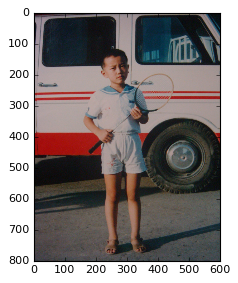

0 [52, 5, 1, 284, 29, 24, 3, 10, 42, 136, 3, 50, 1, 14, 9]
0 道路/上/的/汽车/旁/走/着/一个/右手/拎/着/包/的/男人/</S> 0.551486047088
[-1.7897456, -0.0020623384, -1.467692, -0.35516945, -0.65653747, -0.43162429, -0.00076336326, -0.1300803, -1.3255548, -1.7976828, -0.0014431786, -0.33439291, -0.010720872, -0.62029499, -0.003316856]
[[ -2.65426373e+00  -1.38842000e-03  -8.92076910e-01  -5.96233234e-02
   -1.73568630e+00  -7.20446169e-01  -2.15802145e+00  -6.53959751e-01
   -8.25576019e-03  -6.66351271e+00  -7.66538596e-03  -1.82344839e-01
   -4.47076350e-01  -2.72970700e+00  -1.30115694e-03]]
[ 0.16829225]
[[ 0.55148602  0.55060792  0.54110223]]
[[ 0.5514859]]
[[ 0.5514859]]
[[ 0.5514859]]
1 [52, 5, 1, 284, 29, 24, 3, 10, 42, 18, 3, 235, 1, 14, 9]
1 道路/上/的/汽车/旁/走/着/一个/右手/拿/着/手机/的/男人/</S> 0.55060804447
[-1.7897456, -0.0020623384, -1.467692, -0.35516945, -0.65653747, -0.43162429, -0.00076336326, -0.1300803, -1.3255548, -1.0475416, -0.022348341, -1.3076984, -0.020456176, -0.38979506, -0.0039113462]
[[ -2.65426

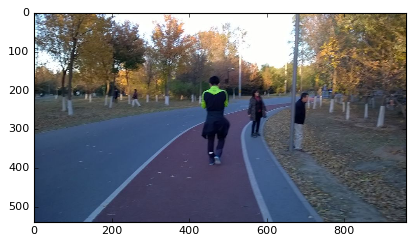

0 [156, 1, 52, 5, 11, 27, 20, 73, 1, 4, 2, 538, 9]
0 平坦/的/道路/上/有/两个/穿着/运动服/的/人/在/跑步/</S> 0.606595959382
[-1.4179151, -0.011530661, -1.1054857, -0.0053715422, -0.22170705, -0.83563119, -0.31269887, -1.5057967, -0.0032096796, -0.90751171, -0.010556689, -0.16004717, -0.0011388728]
[[ -1.46483493e+00  -2.06489429e-01  -2.71711731e+00  -6.18951201e-01
   -2.30742209e-02  -8.63925815e-01  -2.92873323e-01  -1.32084303e+01
   -3.02049041e+00  -5.08004904e-01  -1.69463921e-02  -2.81139761e-01
   -1.54006565e-02  -2.25810573e-01  -3.23427655e-03]]
[ 0.26874185]
[[ 0.60659599  0.60500318  0.59335285]]
[[ 0.60659599]]
[[ 0.60659599]]
[[ 0.60659599]]
1 [156, 1, 52, 5, 11, 27, 20, 258, 90, 1, 4, 2, 538, 9]
1 平坦/的/道路/上/有/两个/穿着/红色/上衣/的/人/在/跑步/</S> 0.60500323078
[-1.4179151, -0.011530661, -1.1054857, -0.0053715422, -0.22170705, -0.83563119, -0.31269887, -1.315141, -0.68388534, -0.0046746968, -0.99234581, -0.019452283, -0.10862505, -0.00083626102]
[[ -4.77585316e+00  -1.46568671e-01  -8.33875407e-03  -1

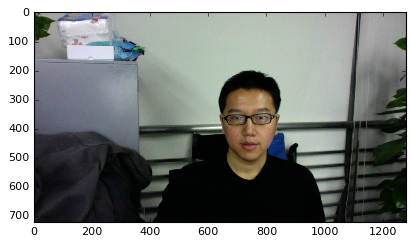

0 [10, 43, 140, 1, 14, 19, 2, 89, 21, 1, 212, 29, 9]
0 一个/戴着/眼镜/的/男人/站/在/房间/里/的/桌子/旁/</S> 0.636009491841
[-0.81385648, -0.94851375, -0.10323625, -0.038276184, -0.10664752, -0.54671174, -0.0015019814, -2.0720458, -0.019994376, -0.33166397, -0.65905654, -0.086225517, -0.15531288]
[[ -8.13856483e-01  -2.54926062e+00  -2.80563545e+00  -9.22575817e-02
   -9.70711038e-02  -2.09984481e-01  -1.55566260e-03  -1.69905341e+00
   -1.34167196e-02  -4.04526651e-01  -5.50734282e-01  -1.13376267e-01
   -3.83705807e+00  -1.20471837e-03]]
[ 0.59881699]
[[ 0.6360094   0.62267649  0.54631144]]
[[ 0.63600934]]
[[ 0.63600934]]
[[ 0.63600934]]
1 [10, 43, 140, 1, 14, 19, 2, 103, 1, 212, 29, 9]
1 一个/戴着/眼镜/的/男人/站/在/室内/的/桌子/旁/</S> 0.622676633989
[-0.81385648, -0.94851375, -0.10323625, -0.038276184, -0.10664752, -0.54671174, -0.0015019814, -1.698195, -0.051840965, -1.1239622, -0.094658129, -0.15733521]
[[ -1.76954782e+00  -9.08255018e-03  -1.32746887e+00  -5.55573292e-02
   -1.37166059e+00  -1.20317352e+00  -1.10

In [ ]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)

In [ ]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:')
  image_name = image_name.strip()
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'
  image_path = os.path.join(image_dir, image_name)
  
  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    continue
    
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)